Import libraries

In [21]:
from helpers import load_csv_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

Load data

In [39]:
data_path='data/dataset/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Classes distribution in y_train

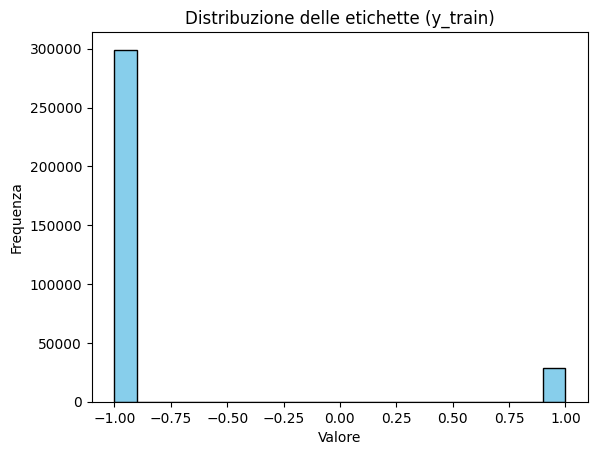

In [40]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Data cleaning from NaN

In [ ]:
missing_counts = np.sum(np.isnan(x_train), axis=0)
missing_percents = missing_counts / x_train.shape[0] * 100

print(f"Number of features with more than 40% of NaN: {np.sum(missing_percents>40)}")

# Drop feature if at least 40% are NaN values
valid_cols_nan = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_clean = x_train[:, valid_cols_nan]
print(x_train_clean.shape)

# For other columns, NaN are replaced with the mean
col_mean = np.nanmean(x_train_clean, axis = 0)  # np.nanmean ignores the NaN
inds =np.where(np.isnan(x_train_clean))
x_train_clean[inds] = col_mean[inds[1]]        #x_train_clean[inds] = np.take(col_mean, inds[1])

Number of features with more than 40% of NaN: 158
(328135, 163)


Data cleaning: highly correlated features

Feature 0 e 68 molto correlate
Feature 2 e 3 molto correlate
Feature 7 e 8 molto correlate
Feature 31 e 103 molto correlate
Feature 65 e 162 molto correlate
Feature 69 e 71 molto correlate
Feature 77 e 93 molto correlate
Feature 85 e 86 molto correlate
Feature 88 e 90 molto correlate
Feature 92 e 94 molto correlate
Feature 92 e 95 molto correlate
Feature 94 e 95 molto correlate
Feature 96 e 97 molto correlate
Feature 107 e 108 molto correlate
Feature 108 e 109 molto correlate
Feature 108 e 110 molto correlate
Feature 108 e 111 molto correlate
Feature 110 e 111 molto correlate
Feature 118 e 119 molto correlate
Feature 118 e 120 molto correlate
Feature 118 e 124 molto correlate
Feature 118 e 128 molto correlate
Feature 119 e 121 molto correlate
Feature 119 e 125 molto correlate
Feature 119 e 129 molto correlate
Feature 120 e 124 molto correlate
Feature 120 e 128 molto correlate
Feature 121 e 125 molto correlate
Feature 121 e 129 molto correlate
Feature 124 e 128 molto correlate
Feature 1

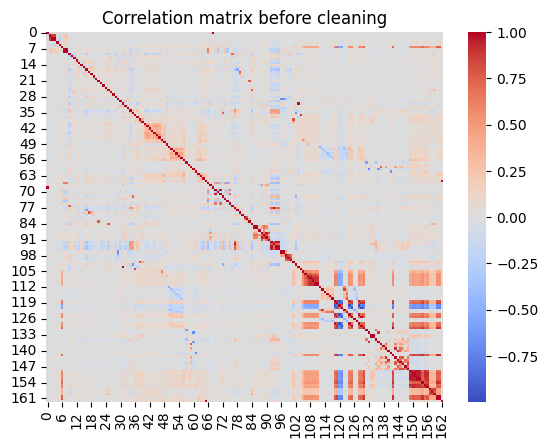

New shape: (328135, 128)


In [ ]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)


for i in range(x_train_clean.shape[1]):
    for j in range(i+1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            print(f"Feature {i} e {j} molto correlate")


corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_new = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
print(f"New shape: {x_train_new.shape}")

Feature  0:    53 valori unici → CATEGORICA
Feature  1:    12 valori unici → CATEGORICA
Feature  2:   414 valori unici → CATEGORICA
Feature  3:    31 valori unici → CATEGORICA
Feature  4:     2 valori unici → CATEGORICA
Feature  5:     2 valori unici → CATEGORICA
Feature  6: 21780 valori unici → CONTINUA
Feature  7:     8 valori unici → CATEGORICA
Feature  8:    34 valori unici → CATEGORICA
Feature  9:    33 valori unici → CATEGORICA
Feature 10:     4 valori unici → CATEGORICA
Feature 11:     5 valori unici → CATEGORICA
Feature 12:     5 valori unici → CATEGORICA
Feature 13:     8 valori unici → CATEGORICA
Feature 14:     7 valori unici → CATEGORICA
Feature 15:     4 valori unici → CATEGORICA
Feature 16:     7 valori unici → CATEGORICA
Feature 17:     5 valori unici → CATEGORICA
Feature 18:     4 valori unici → CATEGORICA
Feature 19:     4 valori unici → CATEGORICA
Feature 20:     5 valori unici → CATEGORICA
Feature 21:     4 valori unici → CATEGORICA
Feature 22:     4 valori unici → C

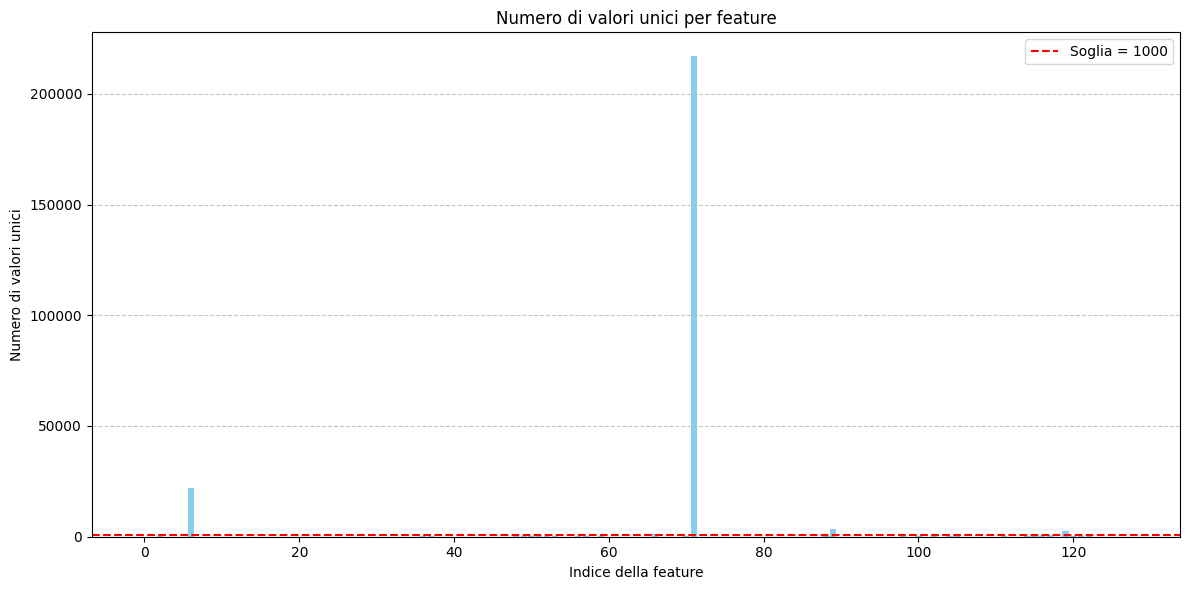

In [46]:
# Soglia per definire se una feature è categorica
threshold = 1000

# Liste per salvare i risultati
categorical_features = []
continuous_features = []
unique_counts = []

# Analisi delle feature
for i in range(x_train_new.shape[1]):
    col = x_train_new[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_features.append(i)
        label = 'CATEGORICA'
    else:
        continuous_features.append(i)
        label = 'CONTINUA'

    print(f"Feature {i:2}: {count:5} valori unici → {label}")

# Riepilogo
print(f"\n Totale feature categoriche (<= {threshold} unique): {len(categorical_features)}")
print(f" Totale feature continue    (>  {threshold} unique): {len(continuous_features)}")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_counts)), unique_counts, color='skyblue')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Soglia = {threshold}')
plt.xlabel('Indice della feature')
plt.ylabel('Numero di valori unici')
plt.title('Numero di valori unici per feature')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Z-score normalization

In [20]:
col_mean_0=np.mean(x_train_clean, axis=0)
col_sd_0=np.std(x_train_clean, axis=0)

x_train_norm=(x_train_clean-col_mean_0)/col_sd_0

col_mean=np.mean(x_train_norm, axis=0)
col_sd=np.std(x_train_norm, axis=0)
print(f"Before normalization, mean: {col_mean_0[0:5]}, sd: {col_sd_0[0:5]}")
print(f"After normalization, mean: {col_mean[0:5]}, sd: {col_sd[0:5]}")



Before normalization, mean: [2.99736511e+01 6.36068996e+00 6.56363820e+06 6.41666083e+00
 1.44962348e+01], sd: [1.60317529e+01 3.48725721e+00 3.48924235e+06 3.49273367e+00
 8.33448235e+00]
After normalization, mean: [-9.84389741e-17  5.97379058e-18 -6.97799371e-18 -8.38279539e-17
 -9.75511611e-17], sd: [1. 1. 1. 1. 1.]
